In [ ]:
import pandas as pd
import numpy as np
import ast
import json
from collections import Counter, defaultdict
from scipy.stats import t,mannwhitneyu,ttest_ind, fisher_exact

In [1547]:
#df_arguments_sentiment = pd.read_csv("sentiment_overview_3.5-turbo_v3.csv")
df_paragraphs_arguments = pd.read_csv("report_arguments_3.5_v3.csv")
df_reports = pd.read_csv("../argument_extraction/production/preprocessed_reports.csv")

In [1548]:
#df_arguments_sentiment = df_arguments_sentiment.drop(columns="Unnamed: 0")
df_paragraphs_arguments = df_paragraphs_arguments.drop(columns=["Unnamed: 0","Unnamed: 0.1","paragraph"])
df_reports = df_reports.drop(columns=["Unnamed: 0","paragraphs"])

In [1549]:
df_paragraphs_arguments

,filename,document_id,paragraph_id,provided_arguments
0,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,1,"{'Technology Trends': 'positive', 'Market Expa..."
1,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,2,"{'Technology Trends': 'positive', 'Partnership..."
2,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,3,"{'Innovation': 'positive', 'Technology Trends'..."
3,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,4,"{'Technology Trends': 'positive', 'Market Shar..."
4,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,5,"{'Growth': 'negative', 'Technology Trends': 'n..."
...,...,...,...,...
12567,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,1,"{'Market Share': 'positive', 'Revenue': 'negat..."
12568,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,2,"{'Market Share': 'positive', 'Growth': 'positi..."
12569,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,3,{'Market Share': 'positive'}
12570,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,4,{'Growth': 'positive'}


<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Argument Aggreation</h2>
</div>

In [1550]:
# Turn string dictionary back to actual dictionary
df_paragraphs_arguments["provided_arguments"] = df_paragraphs_arguments["provided_arguments"].apply(ast.literal_eval)

In [1551]:
#1. Step -> create additional columns that contain the arguments/sentiments as a list, this way the argument can be multiple times per document (not possibel in dictionary)
df_paragraphs_arguments['argument_list'] = df_paragraphs_arguments['provided_arguments'].apply(lambda x: list(x.keys()))
df_paragraphs_arguments['sentiment_list'] = df_paragraphs_arguments['provided_arguments'].apply(lambda x: list(x.values()))

In [1552]:
# Calculate unique amount of arguments from paragraphs
unique_arguments = set(value for sublist in df_paragraphs_arguments["argument_list"] for value in sublist)

print(f"Initial amounf of unique arguments {len(unique_arguments)}")

Initial amounf of unique arguments 385


In [1553]:
## Mapping before ratios are getting created
mapping = {
    "Growth":["Sales Growth","Earnings Growth"],
    "Price/Earnings Ratio":[],
    "Earnings per Share":["EPS"],
    "Cash Flow":["Cash Position","Cash Management","Liquidity","Working Capital","Free Cash Flow"],
    "Revenue":["Revenue Growth","Sales","Operating Income","Deferred Revenue","Revenue Recognition"],
    "Return On Equity":["Return On Invested Capital","Return On Tangible Common Equity","Return On Assets","Return On Capital Employed"],
    "Margins":["EBITDA","Gross Margin","Net Income","EBIT Margin","Gross Profits","Net Interest Margin","Margins Expansion","Gross Margin Return on Inventory","EBITDA Margin","Operating Margin"],
    "Cost Management":["Expenses","Operating Expenses","SG&A","Operating Expense","Spending","Cost Reduction"],
    "Dividend Policy":[],
    "Investments":["Capital Expenditure","Capex Allocation"],
    "Balance Sheet":["Capital Allocation","Debt Reduction","Capital Adequacy","Asset Sale","Equities","Asset Management","Loan Growth"],
    "Long-term Growth":[],
    "Mergers and Acquisition":["Acquisition","Acquisitions"],
    "Refranchising":["Franchise Management","Franchising"],
    "Sustainability":["Environmental Impact","Emissions Reduction","Energy Transition"],
    "Employees":["Intellectual Property","Talent Management","Labor Challenges","Employee Satisfaction"],
    "Research and Development":["Product Development","Drug Development","Product Launch"],
    "Marketing":["Advertising","Brand Image","Promotions","Sales & Marketing"],
    "Shares Repurchase":["Share Buyback","Stock Repurchase","Stock Buyback"],
    "Processes":["Productivity","Efficiency"],
    "Leadership":["Management"],
    "Innovation":["Product Innovation"],
    "Product Characteristics":[],
    "Pricing Strategy":["Price Impact"],
    "Production":[],
    "Technology Trends":["Digital Transformation","Digital Initiatives"],
    "Market Share":[],
    "Market Conditions":[],
    "Market Expansion":["International Expansion"],
    "Competition":["Competitive Position"],
    "Global Presence":["Global Expansion"],
    "Industry Outlook":["Market Trends"],
    "Regulations":["Regulatory Issues","Legal Issues","Privacy","Political Environment","Regulatory Approval"],
    "Partnerships and Collaborations":["Partnerships","Collaboration","Partnerships and Collaboration","Collaborations"],
    "Supply Chain":[],
    "Economic Conditions":["Interest Rates","Net Interest Income","Inflation", "Global Economic Conditions"],
    "Demand":["User Growth","Market Growth"],
    "Customer":["Customer Experience","Customer","Customer Acquisition","Customer Service","Customer Retention", "Customer Engagement","User Engagement","Customer","Customer Protection","Customers"],
    "Currency":["Currency Exchange","Currency Impact","Foreign Exchange"],
    "Taxes":["Tax Rate","Tax Policy Impact","Tax Liability","Tax Impact","Taxes"],
    "Inventory Management":["Inventory"],
    "Earnings Forecast":["Earnings Guidance"],
    "Financial Performance":["Financial Strength","Earnings Quality"]
}


reverse_mapping = {v: k for k, values in mapping.items() for v in values}

# Function to map arguments to their broader categories
def map_arguments(argument_list, reverse_mapping):
    return [reverse_mapping.get(arg, arg) for arg in argument_list]

# Apply the mapping function to the `argument_list` column
df_paragraphs_arguments["argument_list"] = df_paragraphs_arguments["argument_list"].apply(
    lambda x: map_arguments(x, reverse_mapping) if isinstance(x, list) else x
)


In [1554]:
df_paragraphs_arguments

,filename,document_id,paragraph_id,provided_arguments,argument_list,sentiment_list
0,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,1,"{'Technology Trends': 'positive', 'Market Expa...","[Technology Trends, Market Expansion]","[positive, negative]"
1,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,2,"{'Technology Trends': 'positive', 'Partnership...","[Technology Trends, Partnerships and Collabora...","[positive, positive]"
2,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,3,"{'Innovation': 'positive', 'Technology Trends'...","[Innovation, Technology Trends, Competition]","[positive, positive, positive]"
3,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,4,"{'Technology Trends': 'positive', 'Market Shar...","[Technology Trends, Market Share, Competition]","[positive, positive, negative]"
4,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,5,"{'Growth': 'negative', 'Technology Trends': 'n...","[Growth, Technology Trends, Competition]","[negative, negative, negative]"
...,...,...,...,...,...,...
12567,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,1,"{'Market Share': 'positive', 'Revenue': 'negat...","[Market Share, Revenue]","[positive, negative]"
12568,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,2,"{'Market Share': 'positive', 'Growth': 'positi...","[Market Share, Growth]","[positive, positive]"
12569,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,3,{'Market Share': 'positive'},[Market Share],[positive]
12570,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,4,{'Growth': 'positive'},[Growth],[positive]


In [1555]:
from collections import Counter

# Function to count sentiments using `argument_list` and `sentiment_list`
def count_sentiments(argument_list, sentiment_list):
    counts = Counter(sentiment_list)  # Count occurrences of each sentiment
    return {
        'positive_arguments': counts.get('positive', 0),
        'neutral_arguments': counts.get('neutral', 0),
        'negative_arguments': counts.get('negative', 0)
    }

df_counts_paragraph = df_paragraphs_arguments.apply(
    lambda row: count_sentiments(row['argument_list'], row['sentiment_list']), axis=1
)

# Expand the dictionary into separate columns and concatenate with the original DataFrame
df_counts_paragraph = pd.DataFrame(df_counts_paragraph.tolist())
df_paragraphs_arguments = pd.concat([df_paragraphs_arguments, df_counts_paragraph], axis=1)

In [1556]:
df_paragraphs_arguments

,filename,document_id,paragraph_id,provided_arguments,argument_list,sentiment_list,positive_arguments,neutral_arguments,negative_arguments
0,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,1,"{'Technology Trends': 'positive', 'Market Expa...","[Technology Trends, Market Expansion]","[positive, negative]",1,0,1
1,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,2,"{'Technology Trends': 'positive', 'Partnership...","[Technology Trends, Partnerships and Collabora...","[positive, positive]",2,0,0
2,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,3,"{'Innovation': 'positive', 'Technology Trends'...","[Innovation, Technology Trends, Competition]","[positive, positive, positive]",3,0,0
3,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,4,"{'Technology Trends': 'positive', 'Market Shar...","[Technology Trends, Market Share, Competition]","[positive, positive, negative]",2,0,1
4,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,5,"{'Growth': 'negative', 'Technology Trends': 'n...","[Growth, Technology Trends, Competition]","[negative, negative, negative]",0,0,3
...,...,...,...,...,...,...,...,...,...
12567,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,1,"{'Market Share': 'positive', 'Revenue': 'negat...","[Market Share, Revenue]","[positive, negative]",1,0,1
12568,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,2,"{'Market Share': 'positive', 'Growth': 'positi...","[Market Share, Growth]","[positive, positive]",2,0,0
12569,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,3,{'Market Share': 'positive'},[Market Share],[positive],1,0,0
12570,20221230_JP_Morgan_AAPL_Apple-_Public_CAICT_Ch...,203,4,{'Growth': 'positive'},[Growth],[positive],1,0,0


In [1557]:
df_counts_reports = df_paragraphs_arguments.groupby('filename',as_index=False)[['positive_arguments','negative_arguments','neutral_arguments']].sum()
df_reports = df_reports.merge(df_counts_reports,on="filename",how='inner',)
df_reports["tp_reached"] = df_reports[["tp reached after 3 months","tp reached after 6 months","tp reached after 9 months","tp reached after 12 months"]].any(axis=1)
df_reports["total_arguments"] = df_reports[["positive_arguments","negative_arguments","neutral_arguments"]].sum(axis=1)
df_reports

,document_id,filename,date,provider,ticker,company_name,industry,target_price,rating,start price,...,adjusted_target_price,tp reached after 3 months,tp reached after 6 months,tp reached after 9 months,tp reached after 12 months,positive_arguments,negative_arguments,neutral_arguments,tp_reached,total_arguments
0,1,20161018_Needham_META_Facebook-_3Q16_Preview_R...,2016-10-11,Needham,META,Meta Platforms Inc.,Communication Services,150.0,buy,128.88,...,150.00,False,False,True,True,15,3,2,True,20
1,2,20200807_Wells_Fargo_META_FB-_2.5B_Person_Plat...,2020-07-31,Wells Fargo,META,Meta Platforms Inc.,Communication Services,300.0,overweight,253.67,...,300.00,True,False,True,True,19,9,1,True,29
2,3,20200918_Barclays_GM_General_Motors-_Time_to_t...,2020-09-14,Barclays,GM,General Motors Co.,Automobile,39.0,overweight,31.18,...,39.00,True,True,True,True,21,0,1,True,22
3,4,20200722_Barclays_BKNG_Booking_Holdings_Inc.-_...,2020-07-16,Barclays,BKNG,Booking Holdings Inc,Travel,1950.0,overweight,1746.79,...,1950.00,False,True,True,True,7,5,2,True,14
4,5,20211104_Deutsche_Bank_X_US_Steel-_3Q21_EBITDA...,2021-10-28,Deutsche Bank,X,United States Steel,Materials,50.0,buy,23.38,...,50.00,False,False,False,False,15,2,1,False,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,913,20150522_Gilford_Securities_Inc_FL_Report_rece...,2015-05-22,Gilford Securities Inc,FL,Foot Locker,Clothing,NaN,buy,63.46,...,NaN,False,False,False,False,14,4,0,False,18
912,914,20200526_Wells_Fargo_HD_HD-_Q2_Rollover_Falls_...,2020-05-19,Wells Fargo,HD,Home Depot Inc.,Consumer Discretionary,270.0,overweight,238.10,...,270.00,True,True,True,True,15,3,1,True,19
913,915,20220125_Deutsche_Bank_WFC_Wells_Fargo-_More_C...,2022-01-17,Deutsche Bank,WFC,Wells Fargo & Co.,Financials,55.0,buy,58.06,...,55.00,True,True,True,True,16,10,5,True,31
914,916,20200212_Barclays_GM_General_Motors-_Waiting_p...,2020-02-06,Barclays,GM,General Motors Co.,Automobile,44.0,overweight,34.33,...,44.00,False,False,False,True,38,12,9,True,59


In [1558]:
df_reports["opinion_score"] = round((df_reports["positive_arguments"] / df_reports["total_arguments"]),2) - round((df_reports["negative_arguments"] / df_reports["total_arguments"]),2)

In [1559]:
df_reports["total_arguments"].sum()

24874

In [1685]:
df_reports[df_reports["opinion_score"]<0]

,document_id,filename,date,provider,ticker,company_name,industry,target_price,rating,start price,...,tp reached after 9 months,tp reached after 12 months,positive_arguments,negative_arguments,neutral_arguments,tp_reached,total_arguments,opinion_score,difference_tp_start_price,difference_tp_start_price_percentage
5,6,20190513_BTIG_PRGO_Perrigo_Company_plc.pdf,2019-05-08,BTIG,PRGO,Perrigo,Healthcare,NaN,neutral,49.18,...,False,False,1,3,2,False,6,-0.33,NaN,NaN
6,7,20221118_JP_Morgan_HD_The_Home_Depot-_Beat_-_T...,2022-11-15,JP Morgan,HD,Home Depot Inc.,Consumer Discretionary,NaN,overweight,311.93,...,False,False,1,6,1,False,8,-0.63,NaN,NaN
8,9,20210506_Wells_Fargo_META_FB-_Strong_1Q-_Navig...,2021-04-29,Wells Fargo,META,Meta Platforms Inc.,Communication Services,415.0,overweight,329.51,...,False,False,8,12,4,False,24,-0.17,85.49,25.944584
12,13,20220804_Wells_Fargo_F_F-_Rising_Costs_Eat_Awa...,2022-07-28,Wells Fargo,F,Ford Motor Co.,Automobile,10.0,underweight,14.00,...,False,False,4,17,3,False,24,-0.54,-4.00,28.571429
23,24,20140130_Needham_EBAY_EBAY-_4Q_Results-_Icahn_...,2014-01-23,Needham,EBAY,eBay Inc.,Consumer Discretionary,NaN,hold,23.12,...,False,False,2,9,4,False,15,-0.47,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,900,20190614_Needham_SIG_Comp_Decline_Continues_De...,2019-06-07,Needham,SIG,Signet Jewelers,Retail,NaN,hold,19.74,...,False,False,3,8,5,False,16,-0.31,NaN,NaN
903,905,20201001_Wells_Fargo_XOM_XOM-_Delineating_The_...,2020-09-23,Wells Fargo,XOM,Exxon Mobil Corp.,Energy,43.0,equal weight,34.39,...,True,True,25,31,15,True,71,-0.09,8.61,25.036348
905,907,20210114_Wells_Fargo_COST_COST-_December_Sales...,2021-01-06,Wells Fargo,COST,Costco Wholesale Corp.,Consumer Staples,360.0,equal weight,370.02,...,False,False,3,6,1,True,10,-0.30,-10.02,2.707962
908,910,20160803_BGC_Partners_AMZN_BGC_AMZN_07272016.pdf,2016-08-03,BGC Partners,AMZN,Amazon.com Inc.,Consumer Discretionary,750.0,hold,37.73,...,False,False,18,20,9,True,47,-0.05,-0.23,0.609594


In [1560]:
# merge dictionaries
def merge_lists(x):
    return [item for sublist in x.dropna() for item in sublist]

df_reports_arguments = df_paragraphs_arguments.groupby(['filename', 'document_id'], as_index=False).agg({
    'argument_list': merge_lists,
    'sentiment_list': merge_lists
})

# Display the result
df_reports_arguments

,filename,document_id,argument_list,sentiment_list
0,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,"[Technology Trends, Market Expansion, Technolo...","[positive, negative, positive, positive, posit..."
1,20140116_Brean_Capital_SIG_SIG-_Some_Pyrite_Mi...,909,"[Market Share, Revenue, Growth, Revenue, Margi...","[positive, positive, positive, positive, negat..."
2,20140116_Brean_Capital_URBN_URBN-_Ups_-_Downs-...,717,"[Competition, Margins, Competition, Revenue, M...","[negative, negative, negative, negative, negat..."
3,20140122_Pivotal_Research_Group_GOOGL_GOOG-_Gr...,917,"[Margins, Long-term Growth, Investments, Margi...","[negative, negative, negative, negative, posit..."
4,20140124_Hilliard_Lyons_PG_Report_received_in_...,574,"[Revenue, Market Share, Margins, Earnings per ...","[positive, positive, negative, positive, posit..."
...,...,...,...,...
911,20221227_JP_Morgan_WFC_Wells_Fargo-_A_New_Surp...,793,"[Regulations, Growth, Regulations, Financial P...","[negative, negative, negative, negative, negat..."
912,20221228_JP_Morgan_UAA_Under_Armour-_Inc.-_Mgm...,908,"[Leadership, Growth, Market Share, Growth, Mar...","[positive, positive, negative, positive, posit..."
913,20221228_Wells_Fargo_FDX_FDX-_Good_News-_Bad_N...,642,"[Margins, Cost Management, Earnings Forecast, ...","[positive, neutral, negative, positive, neutra..."
914,20221229_JP_Morgan_MUR_Murphy-_The_Road_Ahead_...,22,"[Stock Performance, Cash Flow, Dividend Policy...","[positive, positive, positive, positive, negat..."


<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Argument Mapping</h2>
</div>

In [1561]:
#df_arguments_sentiment.to_csv("full_list_arguments_3.5.csv")

In [1562]:
from collections import defaultdict, Counter
import pandas as pd

def aggregate_sentiment_counts(df, argument_col="argument_list", sentiment_col="sentiment_list"):

    # Initialize a defaultdict for counting sentiments
    sentiment_counts = defaultdict(lambda: Counter({'positive': 0, 'neutral': 0, 'negative': 0}))
    
    # Iterate over rows in the DataFrame
    for _, row in df.iterrows():
        argument_list = row[argument_col]
        sentiment_list = row[sentiment_col]
        
        # Ensure both are lists of the same length
        if isinstance(argument_list, list) and isinstance(sentiment_list, list) and len(argument_list) == len(sentiment_list):
            for argument, sentiment in zip(argument_list, sentiment_list):
                if isinstance(argument, str) and isinstance(sentiment, str):
                    sentiment_counts[argument][sentiment] += 1
                else:
                    print(f"Skipping invalid argument-sentiment pair: {argument}, {sentiment}")
    
    # Convert the counts to a DataFrame
    sentiment_overview_df = pd.DataFrame(sentiment_counts).T
    sentiment_overview_df.columns = ["positive", "neutral", "negative"]
    sentiment_overview_df.index.name = "Argument"
    
    # Reset the index for easier viewing
    sentiment_overview_df.reset_index(inplace=True)
    
    # Sort by positive, then negative, then neutral counts
    sentiment_overview_df.sort_values(by=["positive", "negative", "neutral"], ascending=False, inplace=True)
    
    return sentiment_overview_df

In [1563]:
# Assume df_paragraphs_arguments is your DataFrame
sentiment_overview_df = aggregate_sentiment_counts(df_paragraphs_arguments, 
                                                   argument_col="argument_list", 
                                                   sentiment_col="sentiment_list")

In [1564]:
print(f"Amounf of arguments after Mapping {len(sentiment_overview_df)}")

Amounf of arguments after Mapping 283


In [1565]:
sentiment_overview_df
sentiment_overview_df["total"] = sentiment_overview_df[["positive","negative","neutral"]].sum(axis=1)
sentiment_overview_df["relative_total"] = (sentiment_overview_df["total"] / sentiment_overview_df["total"].sum())
sentiment_overview_df = sentiment_overview_df.sort_values('total',ascending=False)
#sentiment_overview_df = sentiment_overview_df[sentiment_overview_df["total"] > 3 ]
sentiment_overview_df.head(10)
#sentiment_overview_df.to_csv("sentiment_overview_part1.csv")

,Argument,positive,neutral,negative,total,relative_total
6,Growth,2621,100,404,3125,0.125633
7,Revenue,2102,272,593,2967,0.119281
8,Margins,850,104,549,1503,0.060425
5,Market Share,938,47,189,1174,0.047198
9,Market Conditions,394,172,550,1116,0.044866
11,Investments,615,140,169,924,0.037147
15,Cost Management,447,77,354,878,0.035298
4,Competition,141,60,591,792,0.031840
13,Earnings per Share,452,127,123,702,0.028222
0,Technology Trends,554,29,54,637,0.025609


# Sentiment Analysis

In [1566]:
# Get dataframe for successful recommendations
df_sentiment_analysis = sentiment_overview_df

# Display the overview DataFrame
df_sentiment_analysis.reset_index(inplace=True)


In [1567]:
# Create Ratio fields
df_sentiment_analysis["argument_importance"] = round((df_sentiment_analysis["total"] / df_sentiment_analysis["total"].sum()),4)
df_sentiment_analysis["positive_ratio"] = round((df_sentiment_analysis["positive"] / df_sentiment_analysis["total"]),4)
df_sentiment_analysis["negative_ratio"] = round((df_sentiment_analysis["negative"] / df_sentiment_analysis["total"]),4)
df_sentiment_analysis["neutral_ratio"] = round((df_sentiment_analysis["neutral"] / df_sentiment_analysis["total"]),4)
df_sentiment_analysis["opinion_score"] = round((df_sentiment_analysis["positive"] / df_sentiment_analysis["total"]),4) - round((df_sentiment_analysis["negative"] / df_sentiment_analysis["total"]),4)

#df_sentiment_analysis["positive"] = df_sentiment_analysis["positive"].apply(lambda x: x.int())
df_sentiment_analysis = df_sentiment_analysis.sort_values(by=["total"],ascending=False)
df_sentiment_analysis["position"] = range(1,len(df_sentiment_analysis)+1)
#df_sentiment_analysis.to_csv("sentiment_overview_part1.csv")

In [1568]:
df_success_evaluation_reports = pd.merge(df_reports_arguments,df_reports[["filename","tp_reached","rating","industry","adjusted_target_price","total_arguments","opinion_score"]],on="filename",how='left')

In [1569]:
df_argument_per_industry_rating = df_success_evaluation_reports

In [1570]:
df_success_evaluation_reports = df_success_evaluation_reports[df_success_evaluation_reports["adjusted_target_price"].notna()]

In [1571]:
df_success_evaluation_reports

,filename,document_id,argument_list,sentiment_list,tp_reached,rating,industry,adjusted_target_price,total_arguments,opinion_score
1,20140116_Brean_Capital_SIG_SIG-_Some_Pyrite_Mi...,909,"[Market Share, Revenue, Growth, Revenue, Margi...","[positive, positive, positive, positive, negat...",True,buy,Retail,88.00,9,0.12
3,20140122_Pivotal_Research_Group_GOOGL_GOOG-_Gr...,917,"[Margins, Long-term Growth, Investments, Margi...","[negative, negative, negative, negative, posit...",True,hold,Communication Services,26.65,58,-0.22
6,20140128_BGC_Partners_EBAY_BGC_EBAY_01_21.2014...,755,"[Revenue, Growth, Investments, Market Share, G...","[negative, positive, positive, positive, posit...",False,buy,Consumer Discretionary,59.00,35,0.37
8,20140131_BGC_Partners_MSFT_BGC_MSFT_01242014.pdf,603,"[Growth, Leadership, Technology Trends, Revenu...","[positive, positive, positive, positive, posit...",False,hold,Technology,35.00,28,0.33
9,20140203_BGC_Partners_AAPL_BGC_AAPL_01272014.pdf,362,"[Risk Management, Price/Earnings Ratio, Compet...","[neutral, neutral, negative, neutral, negative...",True,hold,Technology,19.64,35,0.06
...,...,...,...,...,...,...,...,...,...,...
907,20221220_Wells_Fargo_MRK_MRK-_MRNA_Cancer_Vacc...,70,"[Earnings, Market Expansion, Product Character...","[positive, positive, positive, positive, posit...",True,overweight,Healthcare,110.00,11,0.73
909,20221221_Wells_Fargo_ABT_ABT-_Exiting_the_Chin...,772,"[Market Share, Revenue, Revenue, Growth, Reven...","[negative, negative, negative, positive, posit...",False,overweight,Healthcare,140.00,6,-0.34
910,20221223_Deutsche_Bank_ADBE_Adobe-_F4Q-_Solid_...,182,"[Financial Performance, Market Conditions, Lon...","[positive, positive, positive, neutral, neutra...",False,buy,Technology,430.00,19,0.42
913,20221228_Wells_Fargo_FDX_FDX-_Good_News-_Bad_N...,642,"[Margins, Cost Management, Earnings Forecast, ...","[positive, neutral, negative, positive, neutra...",False,equal weight,Industrials,185.00,12,0.17


<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Successful Reports</h2>
</div>

In [1572]:
df_success_reports = df_success_evaluation_reports[df_success_evaluation_reports["tp_reached"]==True]

df_success_reports = df_success_reports[df_success_reports["rating"]!= "none"]


Shapiro-Wilk Test: Statistic=0.6901464462280273, P-Value=7.154012532804579e-26


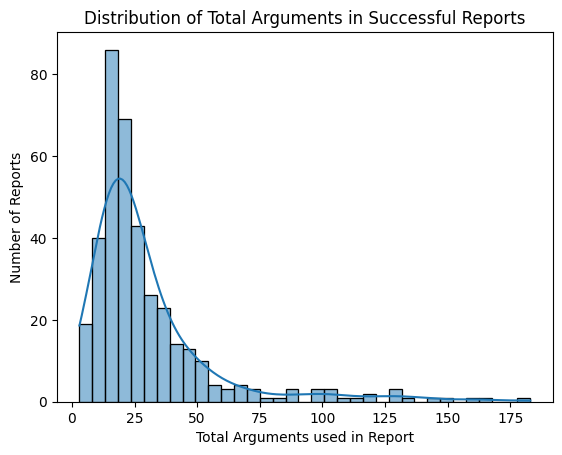

In [1573]:
from scipy.stats import shapiro, kstest
import matplotlib.pyplot as plt
import seaborn as sns

# Check normality
data = df_success_reports["total_arguments"].tolist()

# Shapiro-Wilk Test
stat, p_value = shapiro(data)
print(f"Shapiro-Wilk Test: Statistic={stat}, P-Value={p_value}")

# Visualize
sns.histplot(data, kde=True)
plt.ylabel("Number of Reports")
plt.xlabel("Total Arguments used in Report")
plt.title('Distribution of Total Arguments in Successful Reports')
plt.show()


In [1647]:
df_success_reports.describe()

,document_id,adjusted_target_price,total_arguments,opinion_score
count,381.000000,381.000000,381.000000,381.000000
mean,461.908136,159.842126,30.349081,0.365433
std,273.746597,277.543229,26.944415,0.385340
min,1.000000,0.620000,3.000000,-0.870000
25%,221.000000,45.000000,15.000000,0.110000
50%,463.000000,90.000000,22.000000,0.400000
75%,714.000000,180.000000,34.000000,0.690000
max,917.000000,2600.000000,183.000000,1.000000


Shapiro-Wilk Test: Statistic=0.967880129814148, P-Value=1.977527546159763e-07


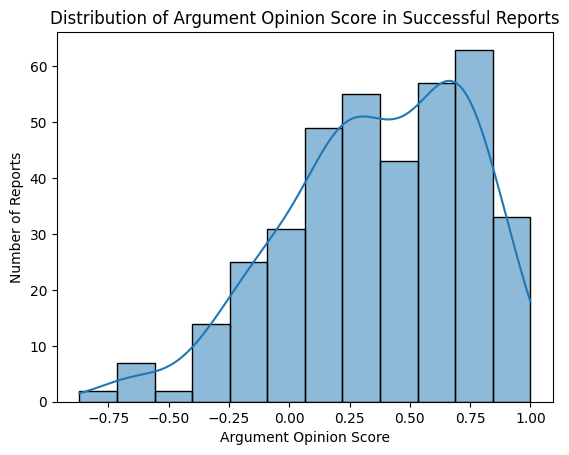

In [1574]:
from scipy.stats import shapiro, kstest
import matplotlib.pyplot as plt
import seaborn as sns

# Check normality
data = df_success_reports["opinion_score"].tolist()

# Shapiro-Wilk Test
stat, p_value = shapiro(data)
print(f"Shapiro-Wilk Test: Statistic={stat}, P-Value={p_value}")

# Visualize
sns.histplot(data, kde=True)
plt.ylabel("Number of Reports")
plt.xlabel("Argument Opinion Score")
plt.title('Distribution of Argument Opinion Score in Successful Reports')
plt.show()


In [1575]:

# Initialize a dictionary to hold counts for each key and sentiment
sentiment_counts_success = defaultdict(lambda: Counter({'positive': 0, 'neutral': 0, 'negative': 0}))

def aggregate_sentiment_counts(df, argument_col="argument_list", sentiment_col="sentiment_list"):

    # Initialize a defaultdict for counting sentiments
    sentiment_counts = defaultdict(lambda: Counter({'positive': 0, 'neutral': 0, 'negative': 0}))
    
    # Iterate over rows in the DataFrame
    for _, row in df.iterrows():
        argument_list = row[argument_col]
        sentiment_list = row[sentiment_col]
        
        # Ensure both are lists of the same length
        if isinstance(argument_list, list) and isinstance(sentiment_list, list) and len(argument_list) == len(sentiment_list):
            for argument, sentiment in zip(argument_list, sentiment_list):
                if isinstance(argument, str) and isinstance(sentiment, str):
                    sentiment_counts[argument][sentiment] += 1
                else:
                    print(f"Skipping invalid argument-sentiment pair: {argument}, {sentiment}")
    
    # Convert the counts to a DataFrame
    df_sentiment_success = pd.DataFrame(sentiment_counts).T
    df_sentiment_success.columns = ["positive", "neutral", "negative"]
    df_sentiment_success.index.name = "Argument"
    
    # Reset the index for easier viewing
    df_sentiment_success.reset_index(inplace=True)
    
    # Sort by positive, then negative, then neutral counts
    df_sentiment_success.sort_values(by=["positive", "negative", "neutral"], ascending=False, inplace=True)
    
    return df_sentiment_success

# Assume df_paragraphs_arguments is your DataFrame
df_sentiment_success = aggregate_sentiment_counts(df_success_reports, 
                                                   argument_col="argument_list", 
                                                   sentiment_col="sentiment_list")



# Display the overview DataFrame
df_sentiment_success.reset_index(inplace=True)
df_sentiment_success["total"] = df_sentiment_success[["positive","negative","neutral"]].sum(axis=1)

In [1576]:
df_sentiment_success

# Count how many reports mention each argument at least once
def count_reports_with_argument(argument, df):
    return df['argument_list'].apply(lambda x: argument in x).sum()

df_sentiment_success['part_of_reports_absolute'] = df_sentiment_success['Argument'].apply(
    lambda arg: count_reports_with_argument(arg, df_success_reports)
)

df_sentiment_success["part_of_reports_relative"] = df_sentiment_success["part_of_reports_absolute"] / 381 #number of successful reports 


In [1577]:
#df_sentiment_success = df_sentiment_success[df_sentiment_success["total"] > 3 ]
df_sentiment_success

,index,Argument,positive,neutral,negative,total,part_of_reports_absolute,part_of_reports_relative
0,2,Growth,1284,43,186,1513,330,0.866142
1,1,Revenue,959,115,239,1313,332,0.871391
2,0,Market Share,475,28,92,595,226,0.593176
3,3,Margins,391,50,255,696,257,0.674541
4,11,Technology Trends,303,16,26,345,113,0.296588
...,...,...,...,...,...,...,...,...
203,165,Crypto Volatility,0,1,0,1,1,0.002625
204,171,Securities,0,1,0,1,1,0.002625
205,178,Executive Changes,0,1,0,1,1,0.002625
206,180,Fees,0,1,0,1,1,0.002625


In [1578]:
# Create Ratio fields
df_sentiment_success["argument_importance"] = round((df_sentiment_success["total"] / df_sentiment_success["total"].sum()),4)
df_sentiment_success["positive_ratio"] = round((df_sentiment_success["positive"] / df_sentiment_success["total"]),4)
df_sentiment_success["negative_ratio"] = round((df_sentiment_success["negative"] / df_sentiment_success["total"]),4)
df_sentiment_success["neutral_ratio"] = round((df_sentiment_success["neutral"] / df_sentiment_success["total"]),4)
df_sentiment_success["opinion_score"] = round((df_sentiment_success["positive"] / df_sentiment_success["total"]),4) - round((df_sentiment_success["negative"] / df_sentiment_success["total"]),4)

df_sentiment_success = df_sentiment_success.sort_values(by=["positive","negative","neutral"],ascending=False)
df_sentiment_success["position"] = range(1,len(df_sentiment_success)+1)
df_sentiment_success.head(30)

,index,Argument,positive,neutral,negative,total,part_of_reports_absolute,part_of_reports_relative,argument_importance,positive_ratio,negative_ratio,neutral_ratio,opinion_score,position
0,2,Growth,1284,43,186,1513,330,0.866142,0.1308,0.8486,0.1229,0.0284,0.7257,1
1,1,Revenue,959,115,239,1313,332,0.871391,0.1136,0.7304,0.1820,0.0876,0.5484,2
2,0,Market Share,475,28,92,595,226,0.593176,0.0515,0.7983,0.1546,0.0471,0.6437,3
3,3,Margins,391,50,255,696,257,0.674541,0.0602,0.5618,0.3664,0.0718,0.1954,4
4,11,Technology Trends,303,16,26,345,113,0.296588,0.0298,0.8783,0.0754,0.0464,0.8029,5
5,7,Investments,259,65,70,394,181,0.475066,0.0341,0.6574,0.1777,0.1650,0.4797,6
6,25,Market Expansion,259,9,26,294,150,0.393701,0.0254,0.8810,0.0884,0.0306,0.7926,7
7,33,Customer,211,26,32,269,131,0.343832,0.0233,0.7844,0.1190,0.0967,0.6654,8
8,12,Cost Management,208,31,157,396,185,0.485564,0.0342,0.5253,0.3965,0.0783,0.1288,9
9,21,Innovation,205,7,17,229,96,0.251969,0.0198,0.8952,0.0742,0.0306,0.8210,10


<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Not Successful Reports</h2>
</div>

In [1579]:
df_unsuccess_reports = df_success_evaluation_reports[df_success_evaluation_reports["tp_reached"]==False]

In [1664]:
df_unsuccess_reports.describe()

,document_id,adjusted_target_price,total_arguments,opinion_score
count,323.000000,323.000000,323.000000,322.000000
mean,453.501548,171.421920,28.213622,0.325342
std,256.177338,291.792584,23.026063,0.385741
min,5.000000,0.500000,0.000000,-0.610000
25%,226.500000,48.000000,14.000000,0.070000
50%,457.000000,90.000000,21.000000,0.375000
75%,667.500000,216.500000,35.000000,0.607500
max,912.000000,2740.000000,139.000000,1.000000


Shapiro-Wilk Test: Statistic=0.747361421585083, P-Value=6.906290675383092e-22


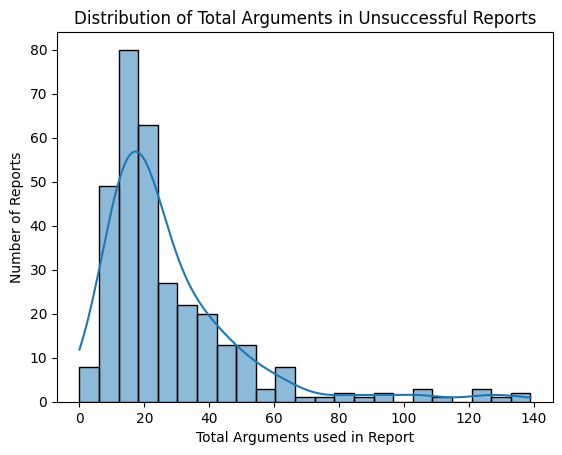

In [1580]:
from scipy.stats import shapiro, kstest
import matplotlib.pyplot as plt
import seaborn as sns

# Check normality
data = df_unsuccess_reports["total_arguments"].tolist()

# Shapiro-Wilk Test
stat, p_value = shapiro(data)
print(f"Shapiro-Wilk Test: Statistic={stat}, P-Value={p_value}")

# Visualize
sns.histplot(data, kde=True)
plt.ylabel("Number of Reports")
plt.xlabel("Total Arguments used in Report")
plt.title('Distribution of Total Arguments in Unsuccessful Reports')
plt.show()


Shapiro-Wilk Test: Statistic=nan, P-Value=1.0


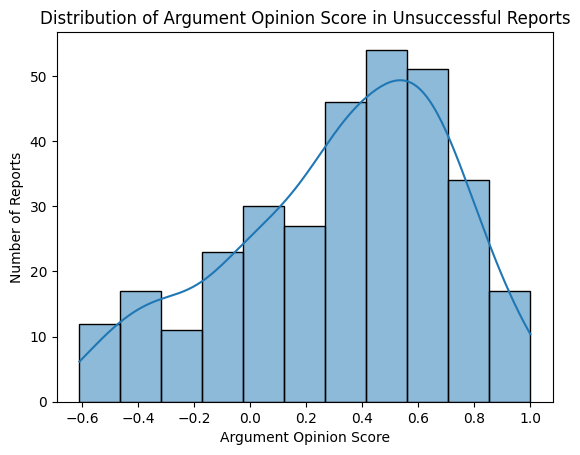

In [1633]:
from scipy.stats import shapiro, kstest
import matplotlib.pyplot as plt
import seaborn as sns

# Check normality
data = df_unsuccess_reports["opinion_score"].tolist()

# Shapiro-Wilk Test
stat, p_value = shapiro(data)
print(f"Shapiro-Wilk Test: Statistic={stat}, P-Value={p_value}")

# Visualize
sns.histplot(data, kde=True)
plt.ylabel("Number of Reports")
plt.xlabel("Argument Opinion Score")
plt.title('Distribution of Argument Opinion Score in Unsuccessful Reports')
plt.show()


In [1582]:

# Initialize a dictionary to hold counts for each key and sentiment
sentiment_counts_success = defaultdict(lambda: Counter({'positive': 0, 'neutral': 0, 'negative': 0}))

def aggregate_sentiment_counts(df, argument_col="argument_list", sentiment_col="sentiment_list"):

    # Initialize a defaultdict for counting sentiments
    sentiment_counts = defaultdict(lambda: Counter({'positive': 0, 'neutral': 0, 'negative': 0}))
    
    # Iterate over rows in the DataFrame
    for _, row in df.iterrows():
        argument_list = row[argument_col]
        sentiment_list = row[sentiment_col]
        
        # Ensure both are lists of the same length
        if isinstance(argument_list, list) and isinstance(sentiment_list, list) and len(argument_list) == len(sentiment_list):
            for argument, sentiment in zip(argument_list, sentiment_list):
                if isinstance(argument, str) and isinstance(sentiment, str):
                    sentiment_counts[argument][sentiment] += 1
                else:
                    print(f"Skipping invalid argument-sentiment pair: {argument}, {sentiment}")
    
    # Convert the counts to a DataFrame
    df_sentiment_unsuccess = pd.DataFrame(sentiment_counts).T
    df_sentiment_unsuccess.columns = ["positive", "neutral", "negative"]
    df_sentiment_unsuccess.index.name = "Argument"
    
    # Reset the index for easier viewing
    df_sentiment_unsuccess.reset_index(inplace=True)
    
    # Sort by positive, then negative, then neutral counts
    df_sentiment_unsuccess.sort_values(by=["positive", "negative", "neutral"], ascending=False, inplace=True)
    
    return df_sentiment_unsuccess

# Assume df_paragraphs_arguments is your DataFrame
df_sentiment_unsuccess = aggregate_sentiment_counts(df_unsuccess_reports, 
                                                   argument_col="argument_list", 
                                                   sentiment_col="sentiment_list")



# Display the overview DataFrame
df_sentiment_unsuccess.reset_index(inplace=True)
df_sentiment_unsuccess["total"] = df_sentiment_unsuccess[["positive","negative","neutral"]].sum(axis=1)

In [1584]:
df_sentiment_unsuccess

# Count how many reports mention each argument at least once
def count_reports_with_argument(argument, df):
    return df['argument_list'].apply(lambda x: argument in x).sum()

df_sentiment_unsuccess['part_of_reports_absolute'] = df_sentiment_unsuccess['Argument'].apply(
    lambda arg: count_reports_with_argument(arg, df_unsuccess_reports)
)

df_sentiment_unsuccess["part_of_reports_relative"] = df_sentiment_unsuccess["part_of_reports_absolute"] / 323 #number of unsuccessful reports 323 


In [1585]:
df_sentiment_unsuccess

,index,Argument,positive,neutral,negative,total,part_of_reports_absolute,part_of_reports_relative
0,1,Growth,916,30,121,1067,280,0.866873
1,0,Revenue,789,80,201,1070,270,0.835913
2,3,Market Share,361,10,70,441,190,0.588235
3,14,Margins,321,28,174,523,214,0.662539
4,2,Investments,244,53,58,355,170,0.526316
...,...,...,...,...,...,...,...,...
184,157,Sales Forecast,0,1,0,1,1,0.003096
185,167,Fees and Costs,0,1,0,1,1,0.003096
186,168,Reserve Build,0,1,0,1,1,0.003096
187,172,Competitors,0,1,0,1,1,0.003096


In [1586]:
# Create Ratio fields
#df_sentiment_unsuccess = df_sentiment_unsuccess[df_sentiment_unsuccess["total"] > 3 ]

df_sentiment_unsuccess["argument_importance"] = round((df_sentiment_unsuccess["total"] / df_sentiment_unsuccess["total"].sum()),4)
df_sentiment_unsuccess["positive_ratio"] = round((df_sentiment_unsuccess["positive"] / df_sentiment_unsuccess["total"]),4)
df_sentiment_unsuccess["negative_ratio"] = round((df_sentiment_unsuccess["negative"] / df_sentiment_unsuccess["total"]),4)
df_sentiment_unsuccess["neutral_ratio"] = round((df_sentiment_unsuccess["neutral"] / df_sentiment_unsuccess["total"]),4)
df_sentiment_unsuccess["opinion_score"] = round((df_sentiment_unsuccess["positive"] / df_sentiment_unsuccess["total"]),4) - round((df_sentiment_unsuccess["negative"] / df_sentiment_unsuccess["total"]),4)

df_sentiment_unsuccess = df_sentiment_unsuccess.sort_values(by=["positive","negative","neutral"],ascending=False)
df_sentiment_unsuccess["position"] = range(1,len(df_sentiment_unsuccess)+1)

df_sentiment_unsuccess.head(20)

,index,Argument,positive,neutral,negative,total,part_of_reports_absolute,part_of_reports_relative,argument_importance,positive_ratio,negative_ratio,neutral_ratio,opinion_score,position
0,1,Growth,916,30,121,1067,280,0.866873,0.1171,0.8585,0.1134,0.0281,0.7451,1
1,0,Revenue,789,80,201,1070,270,0.835913,0.1174,0.7374,0.1879,0.0748,0.5495,2
2,3,Market Share,361,10,70,441,190,0.588235,0.0484,0.8186,0.1587,0.0227,0.6599,3
3,14,Margins,321,28,174,523,214,0.662539,0.0574,0.6138,0.3327,0.0535,0.2811,4
4,2,Investments,244,53,58,355,170,0.526316,0.0390,0.6873,0.1634,0.1493,0.5239,5
5,17,Market Expansion,197,4,20,221,122,0.377709,0.0243,0.8914,0.0905,0.0181,0.8009,6
6,13,Technology Trends,174,8,16,198,81,0.250774,0.0217,0.8788,0.0808,0.0404,0.7980,7
7,6,Cash Flow,170,15,44,229,107,0.331269,0.0251,0.7424,0.1921,0.0655,0.5503,8
8,27,Customer,166,17,20,203,96,0.297214,0.0223,0.8177,0.0985,0.0837,0.7192,9
9,21,Innovation,162,2,7,171,84,0.260062,0.0188,0.9474,0.0409,0.0117,0.9065,10


<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Comparison of Success</h2>
</div>

https://stackoverflow.com/questions/52783391/how-to-merge-dictionaries-of-a-pandas-dataframe-when-grouping-by-rows

In [1587]:
# Merge the two DataFrames on 'Argument' to align rows
merged_df = pd.merge(df_sentiment_success, df_sentiment_unsuccess, on='Argument', suffixes=('_df1', '_df2'),how="outer")
merged_df = merged_df.fillna(0)
merged_df["average_total"] = np.where(
    (merged_df["total_df1"] + merged_df["total_df2"]) / 2 == 0,
    np.maximum(merged_df["total_df1"], merged_df["total_df2"]),
    (merged_df["total_df1"] + merged_df["total_df2"]) / 2
)

In [1588]:
merged_df

,index_df1,Argument,positive_df1,neutral_df1,negative_df1,total_df1,part_of_reports_absolute_df1,part_of_reports_relative_df1,argument_importance_df1,positive_ratio_df1,...,total_df2,part_of_reports_absolute_df2,part_of_reports_relative_df2,argument_importance_df2,positive_ratio_df2,negative_ratio_df2,neutral_ratio_df2,opinion_score_df2,position_df2,average_total
0,127.0,API Integration,1.0,0.0,0.0,1.0,1.0,0.002625,0.0001,1.0,...,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5
1,75.0,Accounting Practices,0.0,1.0,1.0,2.0,2.0,0.005249,0.0002,0.0,...,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,1.0
2,125.0,Ad ARPU,1.0,0.0,0.0,1.0,1.0,0.002625,0.0001,1.0,...,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5
3,199.0,Apparel Recovery,0.0,0.0,1.0,1.0,1.0,0.002625,0.0001,0.0,...,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5
4,141.0,Asset-Light Models,1.0,0.0,0.0,1.0,1.0,0.002625,0.0001,1.0,...,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,186.0,Volume,0.0,0.0,1.0,1.0,1.0,0.002625,0.0001,0.0,...,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5
255,205.0,Volume Growth,0.0,0.0,1.0,1.0,1.0,0.002625,0.0001,0.0,...,1.0,1.0,0.003096,0.0001,1.0,0.0,0.0,1.0,135.0,1.0
256,0.0,Volume Leverage,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,...,2.0,1.0,0.003096,0.0002,1.0,0.0,0.0,1.0,98.0,1.0
257,128.0,Workflow Integration,1.0,0.0,0.0,1.0,1.0,0.002625,0.0001,1.0,...,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5


In [1589]:
# Calculate differences for all numeric columns (excluding 'Argument')
difference_df = merged_df[['Argument',"average_total"]].copy()  # Start with the 'Argument' column
columns_to_compare = [col for col in df_sentiment_success.columns if col != 'Argument' and col != 'average_total']  # Columns to compute differences for

for col in columns_to_compare:
    difference_df[col + '_difference'] = merged_df[col + '_df1'] - merged_df[col + '_df2']

In [1590]:
difference_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Argument                             259 non-null    object 
 1   average_total                        259 non-null    float64
 2   index_difference                     259 non-null    float64
 3   positive_difference                  259 non-null    float64
 4   neutral_difference                   259 non-null    float64
 5   negative_difference                  259 non-null    float64
 6   total_difference                     259 non-null    float64
 7   part_of_reports_absolute_difference  259 non-null    float64
 8   part_of_reports_relative_difference  259 non-null    float64
 9   argument_importance_difference       259 non-null    float64
 10  positive_ratio_difference            259 non-null    float64
 11  negative_ratio_difference       

In [1591]:
difference_df.to_csv("difference_testing.csv")

<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Statistical Significance</h2>
</div>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html

# Overall Argument Usage (WhitneyU Test)
- Why Whitneyu and not t-test 
-> data is not normally distributed but right skewed -> even though sample size is big it's still affecting the results

In [ ]:

# Replace these lists with your raw data
successful_arguments = df_success_reports["total_arguments"].tolist()  # Data for successful group
unsuccessful_arguments = df_unsuccess_reports["total_arguments"].tolist()  # Data for unsuccessful group

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(successful_arguments, unsuccessful_arguments, alternative='two-sided')

# Print the results
print(f"Mann-Whitney U statistic: {stat}")
print(f"P-value: {p_value:.6f}")

# Interpretation
if p_value <= 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

Mann-Whitney U statistic: 64420.5
P-value: 0.282511
There is no significant difference between the two groups.


# Overall Opinion Score (WhitneyU Test)

In [1684]:
from scipy.stats import permutation_test

# Replace these lists with your raw data
successful_opinion_score = df_success_reports["opinion_score"].tolist()  # Data for successful group
unsuccessful_opinion_score = df_unsuccess_reports["opinion_score"].tolist()  # Data for unsuccessful group

successful_clean = [x for x in successful_opinion_score if not np.isnan(x)]
unsuccessful_clean = [x for x in unsuccessful_opinion_score if not np.isnan(x)]

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(successful_clean, unsuccessful_clean, alternative='two-sided')

# Print the results
print(f"Mann-Whitney U statistic: {stat}")
print(f"P-value: {p_value:.6f}")

# Interpretation
if p_value <= 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

Mann-Whitney U statistic: 65006.0
P-value: 0.171943
There is no significant difference between the two groups.


# T-Test
-> Whitney U is better because the distribution is right skewed

In [ ]:
successful_count = 381
not_successful_count = 323

# Opinion Score data
std_opn_success = 0.385340
std_opn_unsuccess = 0.385741
success_opinion_score = 0.363
unsuccess_opinion_score = 0.325

# Check to prevent division by zero and handle small sample sizes
# Calculate pooled standard error
se = ((std_opn_success**2 / successful_count) + (std_opn_unsuccess**2 / not_successful_count))**0.5

# Calculate t-statistic
t_stat_opinion = (success_opinion_score - unsuccess_opinion_score) / se

# Degrees of freedom (Welch-Satterthwaite approximation)
df = ((std_opn_success**2 / successful_count + std_opn_unsuccess**2 / not_successful_count)**2 /
    (((std_opn_success**2 / successful_count)**2 / (successful_count - 1)) +
    ((std_opn_unsuccess**2 / not_successful_count)**2 / (not_successful_count - 1))))

# Calculate p-value (two-tailed)
p_value_opinion = 2 * (1 - t.cdf(abs(t_stat_opinion), df))
p_value_opinion = "{:.6f}".format(p_value_opinion)

## Argument Calculation
std_arguments_success = 26.944
std_arguments_unsuccess = 23.026
success_arguments = 30.35
unsuccess_arguments = 28.21

# Calculate pooled standard error
se_arguments = ((std_arguments_success**2 / successful_count) + (std_arguments_unsuccess**2 / not_successful_count))**0.5

# Calculate t-statistic
t_stat_arguments = (success_arguments - unsuccess_arguments) / se_arguments

# Degrees of freedom (Welch-Satterthwaite approximation)
df_arguments = ((std_arguments_success**2 / successful_count + std_arguments_unsuccess**2 / not_successful_count)**2 /
    (((std_arguments_success**2 / successful_count)**2 / (successful_count - 1)) +
    ((std_arguments_unsuccess**2 / not_successful_count)**2 / (not_successful_count - 1))))

# Calculate p-value (two-tailed)
p_value_arguments = 2 * (1 - t.cdf(abs(t_stat_arguments), df_arguments))
p_value_arguments = "{:.6f}".format(p_value_arguments)


print(f"p-value for opinion score: {p_value_opinion}")
print(f"p-value for arguments: {p_value_arguments}")

p-value for opinion score: 0.192985
p-value for arguments: 0.256225


In [1638]:
merged_df

,index_df1,Argument,positive_df1,neutral_df1,negative_df1,total_df1,part_of_reports_absolute_df1,part_of_reports_relative_df1,argument_importance_df1,positive_ratio_df1,...,part_of_reports_relative_df2,argument_importance_df2,positive_ratio_df2,negative_ratio_df2,neutral_ratio_df2,opinion_score_df2,position_df2,average_total,relative_usage_df1,relative_usage_df2
0,127.0,API Integration,1.0,0.0,0.0,1.0,1.0,0.002625,0.0001,1.0,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5,0.000086,0.000000
1,75.0,Accounting Practices,0.0,1.0,1.0,2.0,2.0,0.005249,0.0002,0.0,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,1.0,0.000173,0.000000
2,125.0,Ad ARPU,1.0,0.0,0.0,1.0,1.0,0.002625,0.0001,1.0,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5,0.000086,0.000000
3,199.0,Apparel Recovery,0.0,0.0,1.0,1.0,1.0,0.002625,0.0001,0.0,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5,0.000086,0.000000
4,141.0,Asset-Light Models,1.0,0.0,0.0,1.0,1.0,0.002625,0.0001,1.0,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5,0.000086,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,186.0,Volume,0.0,0.0,1.0,1.0,1.0,0.002625,0.0001,0.0,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5,0.000086,0.000000
255,205.0,Volume Growth,0.0,0.0,1.0,1.0,1.0,0.002625,0.0001,0.0,...,0.003096,0.0001,1.0,0.0,0.0,1.0,135.0,1.0,0.000086,0.000110
256,0.0,Volume Leverage,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,...,0.003096,0.0002,1.0,0.0,0.0,1.0,98.0,1.0,0.000000,0.000219
257,128.0,Workflow Integration,1.0,0.0,0.0,1.0,1.0,0.002625,0.0001,1.0,...,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.5,0.000086,0.000000


In [ ]:
# Precompute totals for efficiency
total_df1_sum = merged_df["total_df1"].sum()
total_df2_sum = merged_df["total_df2"].sum()

# Create lists to store test results
statistical_significance_values = []

# Loop through each argument
for _, row in merged_df.iterrows():
    argument = row["Argument"]

    # Fisher's Exact Test for absolute counts
    successful_count = row["total_df1"]
    not_successful_count = row["total_df2"]
    other_successful_count = total_df1_sum - successful_count
    other_not_successful_count = total_df2_sum - not_successful_count

    contingency_table = [[successful_count, other_successful_count],
                         [not_successful_count, other_not_successful_count]]
    odds_ratio, p_value_fishers = fisher_exact(contingency_table, alternative='two-sided')

    # Calculate relative usage (proportions)
    relative_usage_success = successful_count / total_df1_sum
    relative_usage_unsuccess = not_successful_count / total_df2_sum

    # Unpaired t-test for relative usage
    # Simulate raw data from proportions
    if successful_count > 1 and not_successful_count > 1:
        success_proportions = relative_usage_success * successful_count
        unsuccess_proportions = relative_usage_unsuccess * not_successful_count

        t_stat, p_value_t = ttest_ind(success_proportions, unsuccess_proportions, equal_var=False)
    else:
        t_stat, p_value_t = None, None

    # Store results
    statistical_significance_values.append({
        "Argument": argument,
        "odds_ratio_total_counts": odds_ratio,
        "p_value_fishers": p_value_fishers,
        "t_stat_relative_usage": t_stat,
        "p_value_t_relative_usage": p_value_t,
        "success_count": successful_count,
        "unsuccess_count": not_successful_count,
        "relative_usage_success": relative_usage_success,
        "relative_usage_unsuccess": relative_usage_unsuccess,
    })

# Create a DataFrame for results
df_results = pd.DataFrame(statistical_significance_values)

# Display results
df_results.sort_values('success_count', ascending=False).head(50)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,Argument,odds_ratio_total_counts,p_value_fishers,t_stat_relative_usage,p_value_t_relative_usage,success_count,unsuccess_count,relative_usage_success,relative_usage_unsuccess
109,Growth,1.135242,0.003003,NaN,NaN,1513.0,1067.0,0.130848,0.117085
198,Revenue,0.962887,0.392374,NaN,NaN,1313.0,1070.0,0.113552,0.117415
141,Margins,1.051940,0.405150,NaN,NaN,696.0,523.0,0.060192,0.057391
148,Market Share,1.066769,0.319805,NaN,NaN,595.0,441.0,0.051457,0.048392
143,Market Conditions,0.905313,0.144971,NaN,NaN,495.0,429.0,0.042809,0.047076
28,Cost Management,0.946793,0.493133,NaN,NaN,396.0,329.0,0.034247,0.036102
124,Investments,0.870279,0.066198,NaN,NaN,394.0,355.0,0.034074,0.038955
19,Competition,1.034021,0.693960,NaN,NaN,384.0,293.0,0.033209,0.032152
238,Technology Trends,1.384713,0.000274,NaN,NaN,345.0,198.0,0.029837,0.021727
145,Market Expansion,1.049710,0.621101,NaN,NaN,294.0,221.0,0.025426,0.024251


In [1697]:
import pandas as pd
from scipy.stats import fisher_exact, t
from statsmodels.stats.proportion import proportions_ztest

# Precompute totals for efficiency
total_df1_sum = merged_df["total_df1"].sum()
total_df2_sum = merged_df["total_df2"].sum()

"""# Standard Deviation from the reports -> retrieved manually from df_success_success_reports/df_unsuccess_reports.describe()
std_success = 0.385340
std_unsuccess = 0.385741"""

# Create lists to store test results
statistical_significance_values = []

# Loop through each argument
for _, row in merged_df.iterrows():
    argument = row["Argument"]

    # create contigency table for Fishers Test -> why Fisher and not chi2 -> many values have a small sample size
    successful_count = row["total_df1"]
    not_successful_count = row["total_df2"]
    other_successful_count = total_df1_sum - successful_count
    other_not_successful_count = total_df2_sum - not_successful_count

    contingency_table = [[successful_count, other_successful_count],
                         [not_successful_count, other_not_successful_count]]

    # Perform Fisher's Exact Test for absolute counts
    odds_ratio_total_counts, p_value_fishers_test_arguments = fisher_exact(contingency_table, alternative='two-sided')

    # Z-Test for relative usage (proportions)
    t_stat, p_value_t = ttest_ind(success_proportions, unsuccess_proportions, equal_var=False)

    # Z-Test for amount of reports
    successful_reports = row["part_of_reports_absolute_df1"]
    unsuccessful_reports = row["part_of_reports_absolute_df2"]

    # Fisher's Exact Test for reports
    contingency_table_reports = [[successful_reports, 381 - successful_reports],
                                  [unsuccessful_reports, 323 - unsuccessful_reports]]
    odds_ratio_unique_reports, p_value_fishers_test_unique_reports = fisher_exact(contingency_table_reports, alternative='two-sided')

    

    # Store results
    statistical_significance_values.append({
        "Argument": argument,
        "odds_ratio_total_counts": odds_ratio_total_counts,
        "p_value_arguments": p_value_fishers_test_arguments,
        "success_count": successful_count,
        "unsuccess_count": not_successful_count,
        "success_reports": successful_reports,
        "unsuccess_reports": unsuccessful_reports,
        "p_value_unique_reports": p_value_fishers_test_unique_reports,
        "odds_ratio_unique_reports": odds_ratio_unique_reports
    })

# Create a DataFrame for results
df_statistical_significance = pd.DataFrame(statistical_significance_values)
df_statistical_significance
# Display the results
#df_statistical_significance.sort_values('success_count', ascending=False).head(50)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,Argument,odds_ratio_total_counts,p_value_arguments,success_count,unsuccess_count,success_reports,unsuccess_reports,p_value_unique_reports,odds_ratio_unique_reports
0,API Integration,inf,1.000000,1.0,0.0,1.0,0.0,1.000000,inf
1,Accounting Practices,inf,0.506997,2.0,0.0,2.0,0.0,0.502687,inf
2,Ad ARPU,inf,1.000000,1.0,0.0,1.0,0.0,1.000000,inf
3,Apparel Recovery,inf,1.000000,1.0,0.0,1.0,0.0,1.000000,inf
4,Asset-Light Models,inf,1.000000,1.0,0.0,1.0,0.0,1.000000,inf
...,...,...,...,...,...,...,...,...,...
254,Volume,inf,1.000000,1.0,0.0,1.0,0.0,1.000000,inf
255,Volume Growth,0.788099,1.000000,1.0,1.0,1.0,1.0,1.000000,0.847368
256,Volume Leverage,0.000000,0.194251,0.0,2.0,0.0,1.0,0.458807,0.000000
257,Workflow Integration,inf,1.000000,1.0,0.0,1.0,0.0,1.000000,inf


In [1644]:
df_statistical_significance.describe()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,odds_ratio,p_absolute,p_value_overall,z_stat_overall,success_count,unsuccess_count,success_reports,unsuccess_reports,p_value_reports,z_stat_reports,p_absolute_reports,odds_ratio_reports,success_opinion_score,unsuccess_opinion_score
count,259.000000,2.590000e+02,2.590000e+02,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,inf,5.721010e-01,3.742344e-01,-0.049234,44.644788,35.185328,20.602317,16.938224,0.414716,0.088014,0.627723,inf,0.160698,0.106739
std,NaN,3.549970e-01,2.706806e-01,1.364939,152.111741,116.423330,49.794151,41.671055,0.276860,1.102833,0.335216,NaN,0.630317,0.611651
min,0.000000,1.811752e-08,1.838626e-08,-5.626538,0.000000,0.000000,0.000000,0.000000,0.007546,-2.671748,0.009094,0.000000,-1.000000,-1.000000
25%,0.394006,2.604950e-01,1.673251e-01,-1.126458,1.000000,0.000000,1.000000,0.000000,0.216040,-1.086851,0.396289,0.526677,0.000000,0.000000
50%,1.003670,5.069967e-01,3.746585e-01,0.030798,2.000000,1.000000,1.000000,1.000000,0.356842,0.086183,0.589885,1.020645,0.000000,0.000000
75%,NaN,1.000000e+00,5.088669e-01,0.887781,13.500000,10.500000,10.000000,8.000000,0.637201,0.921398,1.000000,NaN,0.712850,0.547500
max,inf,1.000000e+00,9.878767e-01,3.920264,1513.000000,1070.000000,332.000000,280.000000,0.997258,2.649825,1.000000,inf,1.000000,1.000000


In [1696]:
df_statistical_significance.to_csv("statistic_significance.csv")

## Create new columns
1. Add TP_Reached_as one column
2. Add total_as_arguments one column

# 2. Replace similar arguments with broader category

# 3. Calculate number of positive / negative / neutral Arguments

# Last Step: Merge Dictionaries

# Report Analysis

<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Report Analysis</h2>
</div>

In [1594]:
from collections import Counter

# Function to get top 3 most frequent arguments
def get_top_arguments(arg_list, n):
    counter = Counter(arg_list)  # Count occurrences of each argument
    most_common = [item[0] for item in counter.most_common(n)]  # Extract top `n` arguments
    return most_common

# Apply the function to argument_list and create new columns
df_reports_arguments['1st_most_used_argument'] = df_reports_arguments['argument_list'].apply(lambda x: get_top_arguments(x, 1)[0] if len(get_top_arguments(x, 1)) > 0 else None)
df_reports_arguments['2nd_most_used_argument'] = df_reports_arguments['argument_list'].apply(lambda x: get_top_arguments(x, 2)[1] if len(get_top_arguments(x, 2)) > 1 else None)
df_reports_arguments['3rd_most_used_argument'] = df_reports_arguments['argument_list'].apply(lambda x: get_top_arguments(x, 3)[2] if len(get_top_arguments(x, 3)) > 2 else None)

In [1595]:
df_final_reports = pd.merge(df_reports,df_reports_arguments,on='filename',how='inner')
df_final_reports['year'] = pd.to_datetime(df_final_reports['date']).dt.year
df_final_reports["opinion_score"] = round((df_final_reports["positive_arguments"] / df_final_reports["total_arguments"]),2) - round((df_final_reports["negative_arguments"] / df_final_reports["total_arguments"]),2)

In [1596]:
pd.reset_option('display.max_colwidth', None)  # Don't truncate column content
df_final_reports

,document_id_x,filename,date,provider,ticker,company_name,industry,target_price,rating,start price,...,tp_reached,total_arguments,opinion_score,document_id_y,argument_list,sentiment_list,1st_most_used_argument,2nd_most_used_argument,3rd_most_used_argument,year
0,1,20161018_Needham_META_Facebook-_3Q16_Preview_R...,2016-10-11,Needham,META,Meta Platforms Inc.,Communication Services,150.0,buy,128.88,...,True,20,0.60,1,"[Revenue, Earnings per Share, Revenue, Revenue...","[positive, positive, positive, positive, posit...",Revenue,Growth,Earnings per Share,2016
1,2,20200807_Wells_Fargo_META_FB-_2.5B_Person_Plat...,2020-07-31,Wells Fargo,META,Meta Platforms Inc.,Communication Services,300.0,overweight,253.67,...,True,29,0.35,2,"[Revenue, Growth, Cost Management, Market Cond...","[positive, neutral, positive, negative, positi...",Revenue,Growth,Market Share,2020
2,3,20200918_Barclays_GM_General_Motors-_Time_to_t...,2020-09-14,Barclays,GM,General Motors Co.,Automobile,39.0,overweight,31.18,...,True,22,0.95,3,"[Growth, Innovation, Market Expansion, Growth,...","[positive, positive, positive, positive, posit...",Innovation,Growth,Market Expansion,2020
3,4,20200722_Barclays_BKNG_Booking_Holdings_Inc.-_...,2020-07-16,Barclays,BKNG,Booking Holdings Inc,Travel,1950.0,overweight,1746.79,...,True,14,0.14,4,"[Revenue, Margins, Market Conditions, Market E...","[negative, negative, positive, positive, posit...",Market Conditions,Revenue,Margins,2020
4,5,20211104_Deutsche_Bank_X_US_Steel-_3Q21_EBITDA...,2021-10-28,Deutsche Bank,X,United States Steel,Materials,50.0,buy,23.38,...,False,18,0.72,5,"[Growth, Investments, Financial Performance, F...","[positive, positive, positive, positive, neutr...",Growth,Financial Performance,Cash Flow,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,913,20150522_Gilford_Securities_Inc_FL_Report_rece...,2015-05-22,Gilford Securities Inc,FL,Foot Locker,Clothing,NaN,buy,63.46,...,False,18,0.56,913,"[Growth, Earnings per Share, Dividend Policy, ...","[positive, positive, positive, positive, posit...",Growth,Earnings per Share,Dividend Policy,2015
912,914,20200526_Wells_Fargo_HD_HD-_Q2_Rollover_Falls_...,2020-05-19,Wells Fargo,HD,Home Depot Inc.,Consumer Discretionary,270.0,overweight,238.10,...,True,19,0.63,914,"[Market Share, Revenue, Sustainability, Financ...","[positive, positive, positive, positive, neutr...",Market Share,Growth,Market Conditions,2020
913,915,20220125_Deutsche_Bank_WFC_Wells_Fargo-_More_C...,2022-01-17,Deutsche Bank,WFC,Wells Fargo & Co.,Financials,55.0,buy,58.06,...,True,31,0.20,915,"[Earnings Forecast, Economic Conditions, Cost ...","[positive, positive, neutral, positive, positi...",Cost Management,Revenue,Economic Conditions,2022
914,916,20200212_Barclays_GM_General_Motors-_Waiting_p...,2020-02-06,Barclays,GM,General Motors Co.,Automobile,44.0,overweight,34.33,...,True,59,0.44,916,"[Valuation, Revenue, Growth, Market Cap, Earni...","[positive, positive, positive, positive, posit...",Growth,Revenue,Valuation,2020


# Opinion Score per Year & Industry

In [1597]:
df_opn_year = df_final_reports.groupby("year").agg(
    opinion_score =('opinion_score','mean'),
    total_reports =('filename','count')
)
df_opn_year

,opinion_score,total_reports
year,,
2014,0.302727,55
2015,0.387037,54
2016,0.394762,42
2017,0.376379,58
2018,0.216102,59
2019,0.374035,57
2020,0.291141,184
2021,0.350055,184
2022,0.284529,223


In [1598]:
df_opn_rating = df_final_reports.groupby("rating").agg(
    opinion_score =('opinion_score','mean'),
    total_reports =('filename','count')
)
df_opn_rating.sort_values('opinion_score',ascending=False)

,opinion_score,total_reports
rating,,
outperform,0.556667,3
buy,0.465812,235
overweight,0.437013,308
underperform,0.426364,11
equal weight,0.145890,73
hold,0.141189,143
neutral,0.124815,81
none,0.096471,17
underweight,0.003158,38


In [1599]:
df_opn_industry = df_final_reports.groupby("industry").agg(
    opinion_score =('opinion_score','mean'),
    total_reports =('filename','count')
)
df_opn_industry

,opinion_score,total_reports
industry,,
Automobile,0.301304,46
Beauty,0.297000,30
Clothing,0.294595,74
Communication Services,0.163939,66
Consumer Discretionary,0.425068,73
Consumer Staples,0.339388,49
Energy,0.255870,46
Financials,0.363438,96
Food,0.498939,66


In [1600]:
df_filtered_success = df_final_reports[(df_final_reports["target_price"].notna()) & (df_final_reports["rating"] != "none")]
df_arguments_success = df_filtered_success.groupby("tp_reached").agg(
    total_arguments =('total_arguments','mean'),
    total_reports =('filename','count')
)
df_arguments_success

,total_arguments,total_reports
tp_reached,,
False,28.213622,323
True,30.349081,381


In [1601]:
df_filtered_success.describe()

,document_id_x,target_price,start price,one day after,max price after 3 months,min price after 3 months,max price after 6 months,min price after 6 months,max price after 9 months,min price after 9 months,max price after 12 months,min price after 12 months,adjusted_target_price,positive_arguments,negative_arguments,neutral_arguments,total_arguments,opinion_score,document_id_y,year
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,703.000000,704.000000,704.000000
mean,458.051136,249.821202,146.720284,146.845682,164.866634,130.891364,166.709105,136.403509,169.088082,140.714290,170.910881,143.589361,165.155014,18.659091,7.732955,2.977273,29.369318,0.347070,458.051136,2019.765625
std,265.675896,479.268253,257.102747,259.113026,294.310509,231.027743,299.458302,243.897069,300.886147,252.455062,308.632280,260.700653,284.024497,18.496787,8.003182,3.833230,25.227330,0.385767,265.675896,2.311554
min,1.000000,0.500000,0.490000,0.480000,0.530000,0.480000,0.570000,0.500000,0.570000,0.480000,0.790000,0.510000,0.500000,0.000000,0.000000,0.000000,0.000000,-0.870000,1.000000,2014.000000
25%,221.750000,55.000000,37.670000,37.670000,42.050000,32.530000,43.010000,34.172500,44.080000,35.355000,42.987500,37.452500,45.000000,8.000000,3.000000,1.000000,15.000000,0.100000,221.750000,2019.000000
50%,459.000000,112.500000,73.815000,73.665000,81.560000,66.025000,83.625000,71.285000,89.870000,71.545000,90.785000,72.280000,90.000000,13.000000,5.000000,2.000000,21.000000,0.390000,459.000000,2020.000000
75%,687.250000,245.000000,175.420000,175.652500,196.632500,156.125000,198.137500,160.162500,202.650000,170.667500,196.000000,172.472500,200.000000,22.000000,10.000000,4.000000,34.250000,0.650000,687.250000,2022.000000
max,917.000000,4400.000000,2437.010000,2618.970000,2648.200000,2074.740000,2703.260000,2085.280000,2703.260000,2067.550000,2618.970000,2144.720000,2740.000000,151.000000,69.000000,43.000000,183.000000,1.000000,917.000000,2022.000000


Shapiro-Wilk Test: Statistic=0.7127768397331238, P-Value=5.3070620183489686e-33


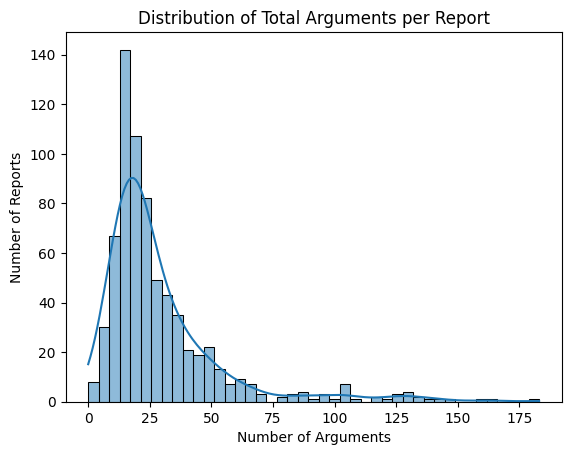

In [1602]:
from scipy.stats import shapiro, kstest
import matplotlib.pyplot as plt
import seaborn as sns

# Check normality
data = df_filtered_success["total_arguments"].tolist()

# Shapiro-Wilk Test
stat, p_value = shapiro(data)
print(f"Shapiro-Wilk Test: Statistic={stat}, P-Value={p_value}")

# Visualize
sns.histplot(data, kde=True)
plt.ylabel("Number of Reports")
plt.xlabel("Number of Arguments")
plt.title('Distribution of Total Arguments per Report')
plt.show()


Shapiro-Wilk Test: Statistic=nan, P-Value=1.0


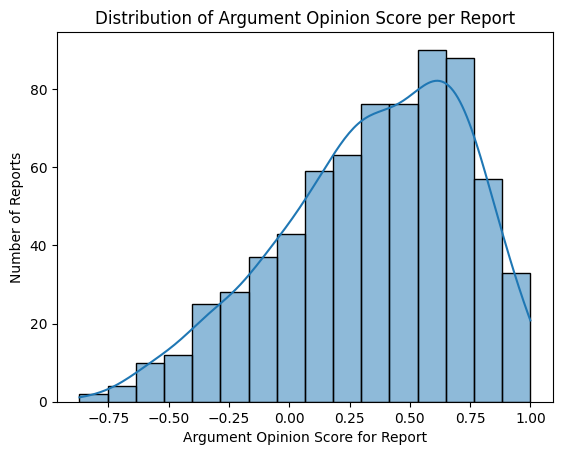

In [1603]:
from scipy.stats import shapiro, kstest
import matplotlib.pyplot as plt
import seaborn as sns

# Check normality
data = df_filtered_success["opinion_score"].tolist()

# Shapiro-Wilk Test
stat, p_value = shapiro(data)
print(f"Shapiro-Wilk Test: Statistic={stat}, P-Value={p_value}")

# Visualize
sns.histplot(data, kde=True)
plt.ylabel("Number of Reports")
plt.xlabel("Argument Opinion Score for Report")
plt.title('Distribution of Argument Opinion Score per Report')
plt.show()


In [1604]:
df_industry_success = df_filtered_success.groupby("industry").agg(
    total_successful =('tp_reached','sum'),
    total_reports =('filename','count')
)
df_industry_success

,total_successful,total_reports
industry,,
Automobile,16,34
Beauty,16,28
Clothing,33,48
Communication Services,28,57
Consumer Discretionary,36,58
Consumer Staples,23,38
Energy,19,33
Financials,34,78
Food,37,59


In [1605]:
df_rating_arguments = df_final_reports.groupby("rating").agg(
    total_arguments =('total_arguments','mean'),
    total_reports =('filename','count')
)
df_rating_arguments

,total_arguments,total_reports
rating,,
buy,30.731915,235
equal weight,26.178082,73
hold,22.951049,143
neutral,25.777778,81
none,19.411765,17
outperform,69.666667,3
overweight,27.769481,308
sell,29.142857,7
underperform,15.363636,11


In [1606]:
#df_filtered = df_final_reports[df_final_reports["target_price"].notna()]
df_opn_industry = df_final_reports.groupby("industry").agg(
    opinion_score =('opinion_score','mean'),
    total_reports =('filename','count')
)
df_opn_industry

,opinion_score,total_reports
industry,,
Automobile,0.301304,46
Beauty,0.297000,30
Clothing,0.294595,74
Communication Services,0.163939,66
Consumer Discretionary,0.425068,73
Consumer Staples,0.339388,49
Energy,0.255870,46
Financials,0.363438,96
Food,0.498939,66


In [1607]:
df_opn_industry_year = df_final_reports.groupby(["industry","year"]).agg(
    opinion_score =('opinion_score','mean'),
    total_reports =('filename','count')
)
df_opn_industry_year

opinion_score  total_reports
industry   year                              
Automobile 2014   3.000000e-02              3
           2015   7.000000e-01              1
           2018   5.000000e-03              2
           2019   2.350000e-01              2
           2020   5.514286e-01              7
...                        ...            ...
Travel     2018  -1.600000e-01              1
           2019  -3.700743e-17              3
           2020   1.410000e-01             10
           2021   9.900000e-02             10
           2022   1.810000e-01             10

[119 rows x 2 columns]

In [1608]:
df_final_reports

,document_id_x,filename,date,provider,ticker,company_name,industry,target_price,rating,start price,...,tp_reached,total_arguments,opinion_score,document_id_y,argument_list,sentiment_list,1st_most_used_argument,2nd_most_used_argument,3rd_most_used_argument,year
0,1,20161018_Needham_META_Facebook-_3Q16_Preview_R...,2016-10-11,Needham,META,Meta Platforms Inc.,Communication Services,150.0,buy,128.88,...,True,20,0.60,1,"[Revenue, Earnings per Share, Revenue, Revenue...","[positive, positive, positive, positive, posit...",Revenue,Growth,Earnings per Share,2016
1,2,20200807_Wells_Fargo_META_FB-_2.5B_Person_Plat...,2020-07-31,Wells Fargo,META,Meta Platforms Inc.,Communication Services,300.0,overweight,253.67,...,True,29,0.35,2,"[Revenue, Growth, Cost Management, Market Cond...","[positive, neutral, positive, negative, positi...",Revenue,Growth,Market Share,2020
2,3,20200918_Barclays_GM_General_Motors-_Time_to_t...,2020-09-14,Barclays,GM,General Motors Co.,Automobile,39.0,overweight,31.18,...,True,22,0.95,3,"[Growth, Innovation, Market Expansion, Growth,...","[positive, positive, positive, positive, posit...",Innovation,Growth,Market Expansion,2020
3,4,20200722_Barclays_BKNG_Booking_Holdings_Inc.-_...,2020-07-16,Barclays,BKNG,Booking Holdings Inc,Travel,1950.0,overweight,1746.79,...,True,14,0.14,4,"[Revenue, Margins, Market Conditions, Market E...","[negative, negative, positive, positive, posit...",Market Conditions,Revenue,Margins,2020
4,5,20211104_Deutsche_Bank_X_US_Steel-_3Q21_EBITDA...,2021-10-28,Deutsche Bank,X,United States Steel,Materials,50.0,buy,23.38,...,False,18,0.72,5,"[Growth, Investments, Financial Performance, F...","[positive, positive, positive, positive, neutr...",Growth,Financial Performance,Cash Flow,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,913,20150522_Gilford_Securities_Inc_FL_Report_rece...,2015-05-22,Gilford Securities Inc,FL,Foot Locker,Clothing,NaN,buy,63.46,...,False,18,0.56,913,"[Growth, Earnings per Share, Dividend Policy, ...","[positive, positive, positive, positive, posit...",Growth,Earnings per Share,Dividend Policy,2015
912,914,20200526_Wells_Fargo_HD_HD-_Q2_Rollover_Falls_...,2020-05-19,Wells Fargo,HD,Home Depot Inc.,Consumer Discretionary,270.0,overweight,238.10,...,True,19,0.63,914,"[Market Share, Revenue, Sustainability, Financ...","[positive, positive, positive, positive, neutr...",Market Share,Growth,Market Conditions,2020
913,915,20220125_Deutsche_Bank_WFC_Wells_Fargo-_More_C...,2022-01-17,Deutsche Bank,WFC,Wells Fargo & Co.,Financials,55.0,buy,58.06,...,True,31,0.20,915,"[Earnings Forecast, Economic Conditions, Cost ...","[positive, positive, neutral, positive, positi...",Cost Management,Revenue,Economic Conditions,2022
914,916,20200212_Barclays_GM_General_Motors-_Waiting_p...,2020-02-06,Barclays,GM,General Motors Co.,Automobile,44.0,overweight,34.33,...,True,59,0.44,916,"[Valuation, Revenue, Growth, Market Cap, Earni...","[positive, positive, positive, positive, posit...",Growth,Revenue,Valuation,2020


In [1609]:
#df_final_reports.to_csv("final_reports_data.csv")

<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Argument usage per unique Report</h2>
</div>

In [1610]:
# Count how many reports mention each argument at least once
def count_reports_with_argument(argument, df):
    return df['argument_list'].apply(lambda x: argument in x).sum()

sentiment_overview_df['part_of_reports_absolute'] = sentiment_overview_df['Argument'].apply(
    lambda arg: count_reports_with_argument(arg, df_reports_arguments)
)

In [1611]:
sentiment_overview_df

,index,Argument,positive,neutral,negative,total,relative_total,argument_importance,positive_ratio,negative_ratio,neutral_ratio,opinion_score,part_of_reports_absolute
0,6,Growth,2621,100,404,3125,0.125633,0.1256,0.8387,0.1293,0.0320,0.7094,771
1,7,Revenue,2102,272,593,2967,0.119281,0.1193,0.7085,0.1999,0.0917,0.5086,766
2,8,Margins,850,104,549,1503,0.060425,0.0604,0.5655,0.3653,0.0692,0.2002,583
3,5,Market Share,938,47,189,1174,0.047198,0.0472,0.7990,0.1610,0.0400,0.6380,498
4,9,Market Conditions,394,172,550,1116,0.044866,0.0449,0.3530,0.4928,0.1541,-0.1398,542
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,219,IT Systems,1,0,0,1,0.000040,0.0000,1.0000,0.0000,0.0000,1.0000,1
279,217,Security,1,0,0,1,0.000040,0.0000,1.0000,0.0000,0.0000,1.0000,1
280,216,Government Policies,1,0,0,1,0.000040,0.0000,1.0000,0.0000,0.0000,1.0000,1
281,199,Gaming Demand,1,0,0,1,0.000040,0.0000,1.0000,0.0000,0.0000,1.0000,1


In [1612]:
total_amount_of_reports = 917

df_grouped_arguments = sentiment_overview_df.sort_values("part_of_reports_absolute",ascending=False)
df_grouped_arguments["part_of_reports_relative"] = df_grouped_arguments["part_of_reports_absolute"] / total_amount_of_reports

In [1613]:
df_grouped_arguments

,index,Argument,positive,neutral,negative,total,relative_total,argument_importance,positive_ratio,negative_ratio,neutral_ratio,opinion_score,part_of_reports_absolute,part_of_reports_relative
0,6,Growth,2621,100,404,3125,0.125633,0.1256,0.8387,0.1293,0.0320,0.7094,771,0.840785
1,7,Revenue,2102,272,593,2967,0.119281,0.1193,0.7085,0.1999,0.0917,0.5086,766,0.835333
2,8,Margins,850,104,549,1503,0.060425,0.0604,0.5655,0.3653,0.0692,0.2002,583,0.635769
4,9,Market Conditions,394,172,550,1116,0.044866,0.0449,0.3530,0.4928,0.1541,-0.1398,542,0.591058
3,5,Market Share,938,47,189,1174,0.047198,0.0472,0.7990,0.1610,0.0400,0.6380,498,0.543075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,195,Earnings Call Focus,0,1,0,1,0.000040,0.0000,0.0000,0.0000,1.0000,0.0000,1,0.001091
212,196,GPU Supply Outlook,0,1,0,1,0.000040,0.0000,0.0000,0.0000,1.0000,0.0000,1,0.001091
211,198,Crypto Demand Impact,0,1,0,1,0.000040,0.0000,0.0000,0.0000,1.0000,0.0000,1,0.001091
210,200,Crypto Volatility,0,1,0,1,0.000040,0.0000,0.0000,0.0000,1.0000,0.0000,1,0.001091


In [1614]:
df_grouped_arguments.to_csv("argument_in_reports_analysis.csv")

<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Industry Analysis</h2>
</div>

In [1615]:
df_argument_per_industry_rating

,filename,document_id,argument_list,sentiment_list,tp_reached,rating,industry,adjusted_target_price,total_arguments,opinion_score
0,20140114_Needham_NVDA_NVDA-_Compelling_Technol...,512,"[Technology Trends, Market Expansion, Technolo...","[positive, negative, positive, positive, posit...",False,hold,Technology,NaN,13,0.24
1,20140116_Brean_Capital_SIG_SIG-_Some_Pyrite_Mi...,909,"[Market Share, Revenue, Growth, Revenue, Margi...","[positive, positive, positive, positive, negat...",True,buy,Retail,88.00,9,0.12
2,20140116_Brean_Capital_URBN_URBN-_Ups_-_Downs-...,717,"[Competition, Margins, Competition, Revenue, M...","[negative, negative, negative, negative, negat...",False,hold,Retail,NaN,8,-1.00
3,20140122_Pivotal_Research_Group_GOOGL_GOOG-_Gr...,917,"[Margins, Long-term Growth, Investments, Margi...","[negative, negative, negative, negative, posit...",True,hold,Communication Services,26.65,58,-0.22
4,20140124_Hilliard_Lyons_PG_Report_received_in_...,574,"[Revenue, Market Share, Margins, Earnings per ...","[positive, positive, negative, positive, posit...",False,neutral,Consumer Staples,NaN,57,0.47
...,...,...,...,...,...,...,...,...,...,...
911,20221227_JP_Morgan_WFC_Wells_Fargo-_A_New_Surp...,793,"[Regulations, Growth, Regulations, Financial P...","[negative, negative, negative, negative, negat...",False,neutral,Financials,NaN,30,-0.66
912,20221228_JP_Morgan_UAA_Under_Armour-_Inc.-_Mgm...,908,"[Leadership, Growth, Market Share, Growth, Mar...","[positive, positive, negative, positive, posit...",False,overweight,Clothing,NaN,24,0.75
913,20221228_Wells_Fargo_FDX_FDX-_Good_News-_Bad_N...,642,"[Margins, Cost Management, Earnings Forecast, ...","[positive, neutral, negative, positive, neutra...",False,equal weight,Industrials,185.00,12,0.17
914,20221229_JP_Morgan_MUR_Murphy-_The_Road_Ahead_...,22,"[Stock Performance, Cash Flow, Dividend Policy...","[positive, positive, positive, positive, negat...",False,overweight,Energy,56.00,28,0.11


In [1616]:
# Explode the argument_list so each argument has its own row
df_exploded = df_argument_per_industry_rating.explode('argument_list')

# Create a pivot table to count the occurrences of each argument per industry
pivot_table = pd.pivot_table(
    df_exploded,
    index='argument_list',
    columns='industry',
    aggfunc='size',
    fill_value=0
)
#pivot_table.to_csv("argument_per_rating.csv")

In [1617]:
pivot_table

industry,Automobile,Beauty,Clothing,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Food,Healthcare,Industrials,Materials,Retail,Technology,Travel
argument_list,,,,,,,,,,,,,,,
API Integration,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Accounting Practices,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
Ad ARPU,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Apparel Recovery,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Asset-Light Models,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Volume Growth,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
Volume Leverage,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
Workflow Integration,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [1618]:
list_of_industries = [
    "Communication Services",
    "Automobile",
    "Travel",
    "Materials",
    "Healthcare",
    "Consumer Discretionary",
    "Energy",
    "Technology",
    "Industrials",
    "Retail",
    "Consumer Staples",
    "Beauty",
    "Financials",
    "Clothing",
    "Food",
]

df_industry_analysis = df_grouped_arguments.drop(columns=["positive","negative","neutral","part_of_reports_absolute","part_of_reports_relative"])

# Initialize columns for each industry
for industry in list_of_industries:
    df_industry_analysis[f'{industry}_absolute'] = 0
    df_industry_analysis[f'{industry}_relative'] = 0.0

# Count absolute and relative mentions per industry
for industry in list_of_industries:
    # Filter reports for the current industry
    industry_reports = df_final_reports[df_final_reports['industry'] == industry]
    total_reports_for_industry = len(industry_reports)

    if total_reports_for_industry > 0:  # Avoid division by zero
        df_industry_analysis[f'{industry}_absolute'] = df_industry_analysis['Argument'].apply(
            lambda arg: industry_reports['argument_list'].apply(lambda x: arg in x).sum()
        )
        df_industry_analysis[f'{industry}_relative'] = round((df_industry_analysis[f'{industry}_absolute'] / total_reports_for_industry),3)

In [1619]:
df_industry_analysis.head(40)

,index,Argument,total,relative_total,argument_importance,positive_ratio,negative_ratio,neutral_ratio,opinion_score,Communication Services_absolute,...,Consumer Staples_absolute,Consumer Staples_relative,Beauty_absolute,Beauty_relative,Financials_absolute,Financials_relative,Clothing_absolute,Clothing_relative,Food_absolute,Food_relative
0,6,Growth,3125,0.125633,0.1256,0.8387,0.1293,0.0320,0.7094,56,...,43,0.878,26,0.867,72,0.750,73,0.986,64,0.970
1,7,Revenue,2967,0.119281,0.1193,0.7085,0.1999,0.0917,0.5086,64,...,46,0.939,24,0.800,88,0.917,59,0.797,61,0.924
2,8,Margins,1503,0.060425,0.0604,0.5655,0.3653,0.0692,0.2002,41,...,34,0.694,25,0.833,42,0.438,61,0.824,51,0.773
4,9,Market Conditions,1116,0.044866,0.0449,0.3530,0.4928,0.1541,-0.1398,35,...,33,0.673,25,0.833,62,0.646,51,0.689,42,0.636
3,5,Market Share,1174,0.047198,0.0472,0.7990,0.1610,0.0400,0.6380,54,...,32,0.653,17,0.567,49,0.510,41,0.554,35,0.530
5,11,Investments,924,0.037147,0.0371,0.6656,0.1829,0.1515,0.4827,43,...,19,0.388,13,0.433,50,0.521,26,0.351,27,0.409
6,15,Cost Management,878,0.035298,0.0353,0.5091,0.4032,0.0877,0.1059,35,...,29,0.592,18,0.600,56,0.583,34,0.459,34,0.515
7,4,Competition,792,0.031840,0.0318,0.1780,0.7462,0.0758,-0.5682,51,...,24,0.490,11,0.367,34,0.354,40,0.541,17,0.258
8,13,Earnings per Share,702,0.028222,0.0282,0.6439,0.1752,0.1809,0.4687,28,...,19,0.388,10,0.333,36,0.375,35,0.473,30,0.455
11,36,Financial Performance,597,0.024001,0.0240,0.6181,0.2931,0.0888,0.3250,24,...,15,0.306,10,0.333,48,0.500,24,0.324,22,0.333


<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Rating Analysis</h2>
</div>

In [1620]:
list_of_ratings = [
    "buy",
    "overweight",
    "neutral",
    "underweight",
    "hold",
    "equal weight",
    "underperform",
    "none",
    "outperform",
    "sell"
]

df_rating_analysis = df_grouped_arguments.drop(columns=["positive","negative","neutral","part_of_reports_absolute","part_of_reports_relative"])

# Initialize columns for each rating
for rating in list_of_ratings:
    df_rating_analysis[f'{rating}_absolute'] = 0
    df_rating_analysis[f'{rating}_relative'] = 0.0

# Count absolute and relative mentions per rating
for rating in list_of_ratings:
    # Filter reports for the current rating
    rating_reports = df_final_reports[df_final_reports['rating'] == rating]
    total_reports_for_rating = len(rating_reports)

    if total_reports_for_rating > 0:  # Avoid division by zero
        df_rating_analysis[f'{rating}_absolute'] = df_rating_analysis['Argument'].apply(
            lambda arg: rating_reports['argument_list'].apply(lambda x: arg in x).sum()
        )
        df_rating_analysis[f'{rating}_relative'] = round((df_rating_analysis[f'{rating}_absolute'] / total_reports_for_rating),3)

In [1621]:
df_rating_analysis.to_csv("rating_argument_analysis.csv")

<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Year Analysis</h2>
</div>

In [1622]:
df_year_analysis = df_grouped_arguments.drop(columns=["positive","negative","neutral","part_of_reports_absolute","part_of_reports_relative"])

In [1623]:
df_year_analysis

,index,Argument,total,relative_total,argument_importance,positive_ratio,negative_ratio,neutral_ratio,opinion_score
0,6,Growth,3125,0.125633,0.1256,0.8387,0.1293,0.0320,0.7094
1,7,Revenue,2967,0.119281,0.1193,0.7085,0.1999,0.0917,0.5086
2,8,Margins,1503,0.060425,0.0604,0.5655,0.3653,0.0692,0.2002
4,9,Market Conditions,1116,0.044866,0.0449,0.3530,0.4928,0.1541,-0.1398
3,5,Market Share,1174,0.047198,0.0472,0.7990,0.1610,0.0400,0.6380
...,...,...,...,...,...,...,...,...,...
213,195,Earnings Call Focus,1,0.000040,0.0000,0.0000,0.0000,1.0000,0.0000
212,196,GPU Supply Outlook,1,0.000040,0.0000,0.0000,0.0000,1.0000,0.0000
211,198,Crypto Demand Impact,1,0.000040,0.0000,0.0000,0.0000,1.0000,0.0000
210,200,Crypto Volatility,1,0.000040,0.0000,0.0000,0.0000,1.0000,0.0000


In [1624]:
years = list(range(2014, 2023))

# Initialize columns for each year
for year in years:
    df_year_analysis[f'{year}_absolute'] = 0
    df_year_analysis[f'{year}_relative'] = 0.0

# Count absolute and relative mentions per year
for year in years:
    # Filter reports for the current year
    year_reports = df_final_reports[df_final_reports['year'] == year]
    total_reports_for_year = len(year_reports)

    if total_reports_for_year > 0:  # Avoid division by zero
        df_year_analysis[f'{year}_absolute'] = df_year_analysis['Argument'].apply(
            lambda arg: year_reports['argument_list'].apply(lambda x: arg in x).sum()
        )
        df_year_analysis[f'{year}_relative'] = round((df_year_analysis[f'{year}_absolute'] / total_reports_for_year),3)

In [1625]:
# Calculate standard deviation and variance for the relative values
relative_columns = [f'{year}_relative' for year in range(2014, 2023)]

df_year_analysis['relative_std_dev'] = df_year_analysis[relative_columns].std(axis=1)
df_year_analysis['relative_variance'] = df_year_analysis[relative_columns].var(axis=1)

In [1626]:
df_year_analysis.head(40)

,index,Argument,total,relative_total,argument_importance,positive_ratio,negative_ratio,neutral_ratio,opinion_score,2014_absolute,...,2019_absolute,2019_relative,2020_absolute,2020_relative,2021_absolute,2021_relative,2022_absolute,2022_relative,relative_std_dev,relative_variance
0,6,Growth,3125,0.125633,0.1256,0.8387,0.1293,0.0320,0.7094,51,...,54,0.947,151,0.821,156,0.848,170,0.762,0.064257,0.004129
1,7,Revenue,2967,0.119281,0.1193,0.7085,0.1999,0.0917,0.5086,48,...,49,0.860,157,0.853,153,0.832,180,0.807,0.031327,0.000981
2,8,Margins,1503,0.060425,0.0604,0.5655,0.3653,0.0692,0.2002,38,...,33,0.579,124,0.674,117,0.636,145,0.650,0.054505,0.002971
4,9,Market Conditions,1116,0.044866,0.0449,0.3530,0.4928,0.1541,-0.1398,39,...,23,0.404,127,0.690,99,0.538,150,0.673,0.111276,0.012382
3,5,Market Share,1174,0.047198,0.0472,0.7990,0.1610,0.0400,0.6380,37,...,29,0.509,98,0.533,96,0.522,111,0.498,0.071214,0.005071
5,11,Investments,924,0.037147,0.0371,0.6656,0.1829,0.1515,0.4827,33,...,31,0.544,79,0.429,83,0.451,111,0.498,0.057630,0.003321
6,15,Cost Management,878,0.035298,0.0353,0.5091,0.4032,0.0877,0.1059,26,...,23,0.404,100,0.543,92,0.500,104,0.466,0.068691,0.004719
7,4,Competition,792,0.031840,0.0318,0.1780,0.7462,0.0758,-0.5682,41,...,26,0.456,77,0.418,68,0.370,69,0.309,0.136604,0.018661
8,13,Earnings per Share,702,0.028222,0.0282,0.6439,0.1752,0.1809,0.4687,37,...,25,0.439,67,0.364,53,0.288,35,0.157,0.207173,0.042921
11,36,Financial Performance,597,0.024001,0.0240,0.6181,0.2931,0.0888,0.3250,14,...,22,0.386,73,0.397,65,0.353,89,0.399,0.071803,0.005156


In [1627]:
df_year_analysis.to_csv("argument_year_analysis.csv")

<div style="background-color: #181818; padding: 5px; border-radius: 20px; text-align: center;">
    <h2 style="font-size: 1.7em;color:#FBFAFA">Target Price Analysis</h2>
</div>

df_reports

In [1628]:
df_reports["difference_tp_start_price"] = df_reports["adjusted_target_price"] - df_reports["start price"]
df_reports["difference_tp_start_price_percentage"] = (df_reports["adjusted_target_price"] - df_reports["start price"]).abs() / df_reports["start price"] * 100

In [1629]:
df_reports.to_csv("reports_data.csv")

In [1630]:
df_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   document_id                           916 non-null    int64  
 1   filename                              916 non-null    object 
 2   date                                  916 non-null    object 
 3   provider                              916 non-null    object 
 4   ticker                                916 non-null    object 
 5   company_name                          916 non-null    object 
 6   industry                              916 non-null    object 
 7   target_price                          705 non-null    float64
 8   rating                                916 non-null    object 
 9   start price                           916 non-null    float64
 10  one day after                         916 non-null    float64
 11  max price after 3 m

In [1631]:
df_grouped_rating = df_reports[df_reports['adjusted_target_price'] > 0]

df_grouped_rating = df_grouped_rating.groupby('rating', as_index=False).agg(
    total_reports=("filename", 'count'),
    average_difference=("difference_tp_start_price_percentage", 'mean'),
)


In [1632]:
df_grouped_rating

,rating,total_reports,average_difference
0,buy,228,34.581394
1,equal weight,73,15.322290
2,hold,57,13.772914
3,neutral,34,14.707363
4,none,1,10.344828
5,outperform,3,19.431983
6,overweight,276,22.621519
7,sell,7,15.418232
8,underperform,1,51.876805
9,underweight,25,29.105807
